# Aufgabe-I-Gezeitenvorhersage

## Allgemeines

Eine allgemeine Beschreibung der Laboraufgaben inklusive des Vorgehens, den Bewertungsrichtlinien und der Abgabe finden Sie  <a href="ML-allgemein.ipynb">hier</a>

## Datenquelle


* Laden Sie ihre Daten von http://141.72.190.207/ml_lab/I_gezeiten herunter
    * Die Daten sind geschützt. 
        * Sie müssen evtl. in einem Netzwerk der DHBW (z.B. WLAN, VPN, ...) angemeldet sein. 
        * Sie können sich auf der Webseite mit dem Benutzernamen dhbw und dem Zugangsnamen "ml_LaB_4$" anmelden. 
* Die Daten sind in einem anwendungsspezifischen Format gespeichert.
    * Sie finden evtl. Informationen über die Daten in einer "README" Datei. 
    * Finden Sie keine solche Datei sind die Daten selbst erklärend. 
    
    



## Aufgabe

Sie haben die Zeitreihen über Gezeiten in der irischen See. Verwenden Sie diese Zeitreihen und erstellen Sie eine Vorhersage für die Gezeitenhöhe an einem Ort und einer Zeit innerhalb der nächsten beiden Jahre.

* Verwenden Sie dazu ein tiefes neuronales Netzwerk!
* Vergleichen Sie die Ergebnisse des tiefen neuronalen Netzwerk mit einem traditionellen ML-Ansatz!


# Lösung

In [1]:
"""
Nötige Imports
"""
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import callbacks

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler


Csv einlesen und checken, ob es Nullwerte gibt. Diese gibt es nicht, also kann ohne Streichen von Zeilen/ Spalten oder Schätzen von fehlende Werten fortgefahren werden.

Die zweite Zeile der CSV (1. Index) kann beim Einlesen direkt übersprungen werden, da hier die Einheiten angegeben sind. Diese stellen im Dataframe aber keinen Nutzen dar.

In [2]:
df = pd.read_csv("data/gezeiten.csv", skiprows=[1])
df.head()
df.isnull().sum()


time               0
longitude          0
latitude           0
stationID          0
Water_Level        0
Water_Level_ODM    0
dtype: int64

### Datenvorverarbeitung

Von Pandas mitgelieferter Ansatz, der StationID ein Label zuzuweisen.
Es gibt auch andere Möglichkeiten, aber dieser Weg erwies sich als sehr schnell und effizient.
Die nicht mehr benötigten Columns können gedropped werden:

- Station ID wurde durch StationIDLabel ersetzt, die Namen der Stationen sind aber weiterhin in Labels gespeichert.
- longitude und latitude sind hier nominale Werte, die sich auf die Station ID beziehen und dienen nicht der Vorhersage der Gezeiten.


In [3]:
"""
Von pandas mitgelieferter ansatz, der StationID ein Label zuzuweisen
"""
# str stationID wird durch int label ersetzt
df['StationID_Label'], labels = pd.factorize(df['stationID'])
print(labels)

# nicht mehr benötigte columns droppen
df = df.drop(columns=["stationID", "longitude", "latitude"])
df.head()

Index(['Achill_Island_MODELLED', 'Aranmore', 'Arklow_MODELLED', 'Ballycotton',
       'Ballyglass', 'Bray_Harbour_MODELLED', 'Carrigaholt_MODELLED',
       'Castletownbere', 'Clare_Island_MODELLED', 'Crosshaven_MODELLED',
       'Dingle_Harbour_MODELLED', 'Dublin_Port', 'Dundalk',
       'Dungarvan_MODELLED', 'Dunmore_East', 'Fenit_MODELLED', 'Galway_Port',
       'Howth', 'Inishmore', 'Killary_Harbour_MODELLED', 'Killybegs',
       'Kinsale_MODELLED', 'Kish_Bank_Lighthouse', 'Lahinch_MODELLED',
       'Letterfrack_MODELLED', 'Malin_Head', 'Rosslare_Port_MODELLED',
       'Skerries', 'Sligo', 'Tory_Island_MODELLED', 'Union_Hall_MODELLED',
       'Wexford', 'Wicklow_MODELLED'],
      dtype='object')


,time,Water_Level,Water_Level_ODM,StationID_Label
0,2017-01-01T00:10:00Z,1.34,-1.23,0
1,2017-01-01T00:20:00Z,1.30,-1.27,0
2,2017-01-01T00:30:00Z,1.26,-1.31,0
3,2017-01-01T00:40:00Z,1.23,-1.34,0
4,2017-01-01T00:50:00Z,1.22,-1.35,0


Überprüfung der Korrelation beider Wasser Level.

Nach dem Sichten des Heads des Dataframe wird vermutet, dass sich die beiden Wasser Level nur um einen konstanten Wert unterscheiden.
Sollte das stimmen, kann eine der beiden Spalten vernachlässigt und gedroppt werden, da sie keinen weiteren Informationsgehalt bietet.

Da bei den über 150000 Werten pro Messstation auch kleinere Schwankungen auftreten, treten in der Differenz für jede Station selbst auch Schwankungen auf.
(Somit gibt es zwischen 2 und 4 verschiedene Offset-Werte). Da diese jedoch erst bei den 3. Nachkommastellen auftreten und diese für eine Vorhersage viel zu klein sind, werden die Wasser Level auf 2 Nachkommastellen gerundet.
Somit gibt es nur noch einen konstanten Wert, um den sich jeweils beide Werte pro Station unterscheiden.

Folgende Schlussfolgerungen lassen sich ziehen:

- Die Spalte "Water_Level_ODM" kann gedropped werden.
- Der Output des Models kann eindimensional sein.


In [4]:
df_water_level_comparison = df[['StationID_Label', "Water_Level", "Water_Level_ODM"]].copy()

df_water_level_comparison["Differenz"] = df_water_level_comparison["Water_Level"] - df_water_level_comparison["Water_Level_ODM"]
df_water_level_comparison = df_water_level_comparison.round(2)
df_water_level_comparison.groupby("StationID_Label")[["Differenz"]].nunique()

df = df.drop(columns=["Water_Level_ODM"])


Aufsplitten der großen CSV Datei in mehrere kleine, sortiert nach den Stationen.
Folgender Vorteile bietet sich hierbei:

Das Einlesen der großen CSV und darauf zu trainieren ist nicht effizient. Um den Trainingsprozess effizienter zu gestalten, wird zunächst auch nur auf einer Station trainiert. Funktioniert die Vorhersage für diese, kann das Model nachfolgend auch auf den gesamten Datensatz angewandt werden

Auffallend hierbei ist, dass es Datensätze mit 157681 oder 262801 Zeilen gibt.
Die Erklärung dafür ist einfach:

- MODELLED Stationen verfügen über weniger Daten, da diese im Abstand von 10 Minuten aufgenommen werden
- die anderen Stationen verfügen über mehr, da hier Zeitintervalle von 6 Minuten vorliegen.

In [6]:
station_groups = df.groupby("StationID_Label")
station_groups.size()

StationID_Label
0     157681
1     262801
2     157681
3     262801
4     262801
5     157681
6     157681
7     262801
8     157681
9     157681
10    157681
11    262801
12    262801
13    157681
14    262801
15    157681
16    262801
17    262801
18    262801
19    157681
20    262801
21    157681
22    262801
23    157681
24    157681
25    262801
26    157681
27    262801
28    262801
29    157681
30    157681
31    262801
32    157681
dtype: int64

In [7]:
for station_id, data in station_groups:
    filename = f"splitted_after_stations/{station_id}-{labels[station_id]}.csv"
    data.to_csv(filename, index=False)

Folgend wird die Zeit aus dem datetime Format in Sekunden umgewandelt. Als Start- und Referenzpunkt dient hier der Zeitstempel, der heraus kommt, wenn man den minimalen Wert der Spalte Time sucht


In [8]:
"""
Time auf Sekunden standardisieren
"""
# str in datetime umwandeln
df['time'] = pd.to_datetime(df['time'])

# min und max wert holen
start_date = df['time'].min()
end_date = df['time'].max()

# jeden timestamp in sec umwandeln
df['timestamps'] = [(t -start_date).total_seconds() for t in df['time']]

df = df.drop(columns=["time"])
df.tail()

,Water_Level,StationID_Label,timestamps
6885388,1.40,32,94606800.0
6885389,1.46,32,94607400.0
6885390,1.52,32,94608000.0
6885391,1.58,32,94608600.0
6885392,1.65,32,94609200.0


In [11]:
"""
Testweise Ausgabe
"""
df1 = df[df["StationID_Label"] == 1]
df1.head()

,Water_Level,StationID_Label,timestamps
157681,1.33,1,0.0
157682,1.29,1,360.0
157683,1.25,1,720.0
157684,1.22,1,1080.0
157685,1.19,1,1440.0


In [5]:
"""
testweises kopieren eines eintrags für lstm model
"""
test_df = df.iloc[156240:157780].copy()
df.drop(index=range(156240,157780), inplace=True)



KeyError: "['Water_Level', 'Water_Level_ODM', 'stationID_label', 'timestamps'] not found in axis"

In [12]:
minmaxscaler = MinMaxScaler()
minmaxscaler.fit(df[["timestamps"]])
df['timestamps'] = minmaxscaler.fit_transform(df[['timestamps']])


"""
Falscher Ansatz, Labels sollten nicht gescaled werden. Nur Features
standardscaler = MinMaxScaler()
standardscaler.fit(df[["Water_Level"]])
df[["Water_Level"]] = standardscaler.transform(df[["Water_Level"]])
scaled_test_df = test_df
scaled_test_df["timestamps"] = minmaxscaler.transform(test_df[["timestamps"]])
scaled_test_df[["Water_Level"]] = standardscaler.transform(test_df[["Water_Level"]])
test_df.tail()

df_labels = df[["Water_Level"]]
df_features = df.drop(columns= ["Water_Level"])"""

'\nFalscher Ansatz, Labels sollten nicht gescaled werden. Nur Features\nstandardscaler = MinMaxScaler()\nstandardscaler.fit(df[["Water_Level"]])\ndf[["Water_Level"]] = standardscaler.transform(df[["Water_Level"]])\nscaled_test_df = test_df\nscaled_test_df["timestamps"] = minmaxscaler.transform(test_df[["timestamps"]])\nscaled_test_df[["Water_Level"]] = standardscaler.transform(test_df[["Water_Level"]])\ntest_df.tail()\n\ndf_labels = df[["Water_Level"]]\ndf_features = df.drop(columns= ["Water_Level"])'

In [16]:
df["inverse_timestamps"] = minmaxscaler.inverse_transform(df[["timestamps"]])
df.head()

,Water_Level,StationID_Label,timestamps,inverse_timestamps
0,1.34,0,0.000006,600.0
1,1.30,0,0.000013,1200.0
2,1.26,0,0.000019,1800.0
3,1.23,0,0.000025,2400.0
4,1.22,0,0.000032,3000.0


In [18]:
df1 = df[df["StationID_Label"] == 1]
df1.head()
df1 = df1.drop(columns="inverse_timestamps")

In [ ]:
"""
Testweise Plotten der Daten
"""
"""
import matplotlib.pyplot as plt
achill_df = df[df['stationID_label'] == 0]

vals = achill_df.head(1000)
plt.ylim()
plt.plot(vals["time"], vals["Water_Level"])
"""

In [19]:
"""
Daten in Labels und Features aufteilen
"""
df_labels = df[["Water_Level"]]
df_features = df.drop(columns= ["Water_Level", "StationID_Label"])
df_labels.head()


In [ ]:
"""
reshape to fit the input in lstm. Still testing
"""
to_take_ind = tf.range(144)[None, :]
to_take_ind = to_take_ind + tf.range(157538)[:, None]

reshaped = tf.gather(df, to_take_ind)



In [21]:
"""
Daten in Trainings- und Validierungsdaten aufteilen. Ich glaube das sollte auch nicht so gemacht werden. Da es sich um Timeseries Data handelt, sollten die Sachen in Place bleiben glaube ich.
"""
features_train, features_test, labels_train, labels_test = train_test_split(df_features, df_labels, test_size=0.3, random_state=42)

features_test, features_val, labels_test, labels_val = train_test_split(features_test, labels_test, test_size=0.5, random_state=42)


In [8]:
train_data = tf.data.Dataset.from_tensor_slices((features_train, labels_train))

buffer_size = 1000
batch_size = 16
# Configure the dataset to optimize performance
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).prefetch(buffer_size)
train_data = train_data.prefetch(tf.data.AUTOTUNE)

In [25]:
steps = (24 * 60 * 28) // 10

features_train = np.reshape(features_train, (features_train.shape[0], 1, features_train.shape[1]))
labels_train = np.reshape(labels_train, (labels_train.shape[0], 1, labels_train.shape[1]))


num_epochs = 150
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(128, input_shape=(steps, 2), return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(2),
])

model.summary()

model.compile(optimizer='adam',
                   loss='mse',
                   metrics=['mse'],)

earlystopping = callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", patience = 3,
                                        restore_best_weights = True)

history = model.fit(features_train, labels_train,
                    epochs=num_epochs,
                    batch_size= 32,
                    verbose=1,
                    callbacks=[earlystopping],
                    validation_data=(features_val, labels_val))

ValueError: cannot reshape array of size 220752 into shape (27,1,4088)

In [22]:
model = tf.keras.models.Sequential([
        #tf.keras.layers.Embedding(input_dim=1, output_dim=16, input_length=2),
        #tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, input_shape=(1, ), activation="relu"),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(2),
])

model.summary()

model.compile(optimizer='adam',
                   loss='mse',
                   metrics=['mae'],)

earlystopping = callbacks.EarlyStopping(monitor ="val_loss",
                                        mode ="min", patience = 5,
                                        restore_best_weights = True)

num_epochs = 150

verlauf = model.fit(features_train["timestamps"], labels_train,
                    epochs=num_epochs,
                    verbose=1,
                    callbacks=[earlystopping],
                    validation_data=(features_val["timestamps"], labels_val))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               512       
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 66,818
Trainable params: 66,818
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
5749/5749 [==============================] - 10s 2ms/step - loss: 0.9279 - mae: 0.8257 - val_loss: 0.8975 - val_mae: 0.8176

In [3]:
results = model.evaluate(features_test["timestamps"], labels_test, verbose=1)

733/733 [==============================] - 1s 2ms/step - loss: 0.0474 - mae: 0.1879

In [20]:
start_time = "2021-01-01T00:00:00Z"
end_time = "2021-01-01T00:10:00Z"
time_range = pd.date_range(start=start_time, end=end_time, freq="10T")

predict_df = pd.DataFrame({"station_ID_Label": [0] * len(time_range), "time": time_range})
predict_df["time"] = pd.to_datetime(predict_df["time"])
predict_df['timestamps'] = [(t -start_date).total_seconds() / 600 for t in predict_df['time']]
predict_df = predict_df.drop(columns=["time"])
print(predict_df.head())

   station_ID_Label  timestamps
0                 0    210384.0
1                 0    210385.0


1/1 [==============================] - 0s 16ms/step


c:\users\benja\pycharmprojects\gezeiten_39\venv\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


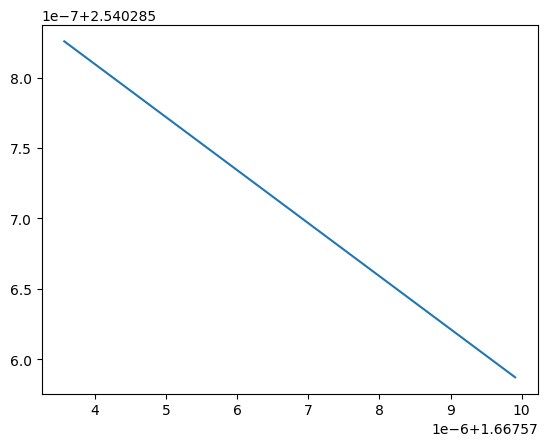

In [19]:
scaled_period_data = minmaxscaler_features.transform(predict_df)
scaled_period_data = np.array(scaled_period_data)
scaled_predictions = model.predict([scaled_period_data])

predictions = minmaxscaler_labels.inverse_transform(scaled_predictions)

predicted_df = pd.DataFrame({'stationID_label': scaled_period_data[:, 0], 'time': scaled_period_data[:, 1], 'Water_Level': predictions[:, 0], 'Water_Level_ODM': predictions[:, 1]})
predicted_df.head()

plt.plot(predicted_df["time"], predicted_df["Water_Level"])

In [4]:
scaled_predictions = model.predict([scaled_test_df["timestamps"]])

predictions = standardscaler.inverse_transform(scaled_predictions)

45/45 [==============================] - 0s 1ms/step


In [20]:
""" # nicht zwingend notwendig
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['stationID']))}
class_mapping
"""


" # nicht zwingend notwendig\nclass_mapping = {label: idx for idx, label in enumerate(np.unique(df['stationID']))}\nclass_mapping\n"

In [21]:
"""
Anderer Ansatz: alles auf etwas einzelnes mappen
"""
df['day'] = df['time'].dt.day
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df = df.drop(columns=['time'])
df.head()

KeyError: 'time'